In [34]:
import pickle
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import numpy as np
import pandas as pd
import yaml
from dataset.SpatialGridder import SpatialGridder
#Load Config

def load_config(path="config/config.yaml"):
    with open(path, "r") as f:
        config = yaml.safe_load(f)
    return config

cfg = load_config()
print("Loaded config:", cfg)
with open("data/drought_train_df.pkl", "rb") as f:
    df_train = pickle.load(f)
with open("data/drought_val_df.pkl", "rb") as f:
    df_val = pickle.load(f)
with open("data/drought_test_df.pkl", "rb") as f:
    df_test = pickle.load(f)

shared_lats = sorted(df_train['lat'].unique())
shared_lons = sorted(df_train['lon'].unique())

# Train
feature_cols = cfg['feature_cols']
target_cols = cfg['target_cols']
lat_key = cfg['lat_key']
lon_key = cfg['lon_key']
time_key = cfg['time_key']
gridder_X_train = SpatialGridder(lat_key=lat_key, lon_key=lon_key, time_key=time_key, feature_cols=feature_cols, lat_vals=shared_lats, lon_vals=shared_lons)
gridder_Y_train = SpatialGridder(lat_key=lat_key, lon_key=lon_key, time_key=time_key, feature_cols=target_cols, lat_vals=shared_lats, lon_vals=shared_lons)
# Val
gridder_X_val = SpatialGridder(lat_key=lat_key, lon_key=lon_key, time_key=time_key, feature_cols=feature_cols, lat_vals=shared_lats, lon_vals=shared_lons)
gridder_Y_val = SpatialGridder(lat_key=lat_key, lon_key=lon_key, time_key=time_key, feature_cols=target_cols, lat_vals=shared_lats, lon_vals=shared_lons)
# Test
gridder_X_test = SpatialGridder(lat_key=lat_key, lon_key=lon_key, time_key=time_key, feature_cols=feature_cols, lat_vals=shared_lats, lon_vals=shared_lons)
gridder_Y_test = SpatialGridder(lat_key=lat_key, lon_key=lon_key, time_key=time_key, feature_cols=target_cols, lat_vals=shared_lats, lon_vals=shared_lons)
# Fit
gridder_X_train.fit(df_train)
gridder_Y_train.fit(df_train)
gridder_X_val.fit(df_val)
gridder_Y_val.fit(df_val)
gridder_X_test.fit(df_test)
gridder_Y_test.fit(df_test)
# Transform
train_grid_data = gridder_X_train.transform(df_train)
val_grid_data = gridder_X_val.transform(df_val)
test_grid_data = gridder_X_test.transform(df_test)
print("train_grid_data shape:", train_grid_data.shape)
print("val_grid_data shape:", val_grid_data.shape)  
print("test_grid_data shape:", test_grid_data.shape)
train_target_data = gridder_Y_train.transform(df_train)
val_target_data = gridder_Y_val.transform(df_val)
test_target_data = gridder_Y_test.transform(df_test)
print("train_target_data shape:", train_target_data.shape)
print("val_target_data shape:", val_target_data.shape)
print("test_target_data shape:", test_target_data.shape)
# Inverse Transform
train_grid_data_inv = gridder_X_train.inverse_transform(train_grid_data)
train_target_data_inv = gridder_Y_train.inverse_transform(train_target_data)
print("Original train_features_ex:", df_train.head())
print("Inverse train_features_ex:", train_grid_data_inv.head())
print("Original train_target_ex:", df_train[target_cols].head())
print("Inverse train_target_ex:", train_target_data_inv.head())

print("Original train_features shape:", df_train[feature_cols].shape)
print("Original train_target shape:", df_train[target_cols].shape)
print("train_grid_data_inv shape:", train_grid_data_inv.shape)
print("train_target_data_inv shape:", train_target_data_inv.shape)



Loaded config: {'feature_cols': ['pet', 'pre', 'tmx', 'tmn', 'tmp', 'cld', 'dmi', 'soi', 'nino3', 'nino4', 'nino34', 'pdo'], 'target_cols': ['spei'], 'lat_key': 'lat', 'lon_key': 'lon', 'time_key': 'time', 'spatial_dim': [30, 17], 'scale_range': [-1, 1]}
train_grid_data shape: (1308, 30, 17, 12)
val_grid_data shape: (120, 30, 17, 12)
test_grid_data shape: (48, 30, 17, 12)
train_target_data shape: (1308, 30, 17, 1)
val_target_data shape: (120, 30, 17, 1)
test_target_data shape: (48, 30, 17, 1)
Original train_features_ex:         time   lat     lon        tmp   dtr   cld        tmx        tmn  \
0 1901-01-16  5.75  101.25  24.500000   9.6  62.5  29.300001  19.700000   
1 1901-01-16  5.75  101.75  24.600000   8.5  63.8  28.900000  20.400000   
2 1901-01-16  6.25  100.75  26.200000  10.1  61.3  31.300001  21.200000   
3 1901-01-16  6.25  101.25  25.300001   9.3  62.5  30.000000  20.700000   
4 1901-01-16  6.25  101.75  25.800001   8.0  65.1  29.800001  21.800001   

     pet         pre   

In [35]:
!python -m inference.predict_and_evaluate --config_path config/best_config.yaml

hidden_dim: [32, 32, 32], kernel_size: [5, 5]
kernel_size: [(5, 5), (5, 5), (5, 5)]
Plotting valid location: lat=0, lon=7
🔍 Train Set
🔍 Shapes: (1288, 1, 30, 17) (1288, 1, 30, 17)
✅ Inverse scaling complete
✅ RMSE: 1.5108 | R²: -1.4179
🔍 Validation Set
🔍 Shapes: (100, 1, 30, 17) (100, 1, 30, 17)
✅ Inverse scaling complete
✅ RMSE: 1.5405 | R²: -1.3957
🧪 Test Set
🔍 Shapes: (28, 1, 30, 17) (28, 1, 30, 17)
✅ Inverse scaling complete
✅ RMSE: 1.7132 | R²: -1.3808
val_preds[0] shape: (1, 30, 17)
val_targets[0] shape: (1, 30, 17)
val_preds[0] values: [[[-1.9636356 -1.962882  -1.9619975 -1.9619582 -1.9619383 -1.9619385
   -1.9619411 -1.9619421 -1.9619404 -1.96194   -1.9619402 -1.9619406
   -1.9619396 -1.9619267 -1.9619914 -1.9625545 -1.9627963]
  [-1.962909  -1.9615769 -1.9600288 -1.9599761 -1.9599441 -1.9599441
   -1.9599432 -1.959943  -1.9599422 -1.9599417 -1.9599425 -1.9599437
   -1.9599406 -1.9599394 -1.9600067 -1.9611987 -1.9615697]
  [-1.9610685 -1.9593283 -1.9579133 -1.9578357 -1.9577998

# Test SpatialGridder

In [36]:
df_train.head()

,time,lat,lon,tmp,dtr,cld,tmx,tmn,pet,pre,wet,vap,dmi,soi,nino3,nino4,nino34,pdo,spei
0,1901-01-16,5.75,101.25,24.500000,9.6,62.5,29.300001,19.700000,105.4,108.100000,1013471,23.9,-0.54,-0.09,26.04,28.85,27.4,0.79,-0.361373
1,1901-01-16,5.75,101.75,24.600000,8.5,63.8,28.900000,20.400000,102.3,141.200000,1148255,24.7,-0.54,-0.09,26.04,28.85,27.4,0.79,-0.511504
2,1901-01-16,6.25,100.75,26.200000,10.1,61.3,31.300001,21.200000,114.7,54.600002,673919,25.7,-0.54,-0.09,26.04,28.85,27.4,0.79,-0.353094
3,1901-01-16,6.25,101.25,25.300001,9.3,62.5,30.000000,20.700000,108.5,84.600000,888191,25.2,-0.54,-0.09,26.04,28.85,27.4,0.79,-0.384595
4,1901-01-16,6.25,101.75,25.800001,8.0,65.1,29.800001,21.800001,102.3,131.500000,1130111,26.7,-0.54,-0.09,26.04,28.85,27.4,0.79,-0.324920


In [37]:
train_grid_data_inv.head()

,time,lat,lon,pet,pre,tmx,tmn,tmp,cld,dmi,soi,nino3,nino4,nino34,pdo
0,1901-01-16,5.75,101.25,105.400002,108.099998,29.300001,19.700001,24.500000,62.500000,-0.54,-0.09,26.040001,28.85,27.4,0.79
1,1901-01-16,5.75,101.75,102.300003,141.199997,28.900000,20.400000,24.600000,63.799999,-0.54,-0.09,26.040001,28.85,27.4,0.79
2,1901-01-16,6.25,100.75,114.699997,54.600002,31.300001,21.200001,26.200001,61.299999,-0.54,-0.09,26.040001,28.85,27.4,0.79
3,1901-01-16,6.25,101.25,108.500000,84.599998,30.000000,20.700001,25.300001,62.500000,-0.54,-0.09,26.040001,28.85,27.4,0.79
4,1901-01-16,6.25,101.75,102.300003,131.500000,29.800001,21.800001,25.800001,65.099998,-0.54,-0.09,26.040001,28.85,27.4,0.79


In [38]:
train_target_data_inv.head()

,time,lat,lon,spei
0,1901-01-16,5.75,101.25,-0.361373
1,1901-01-16,5.75,101.75,-0.511504
2,1901-01-16,6.25,100.75,-0.353094
3,1901-01-16,6.25,101.25,-0.384595
4,1901-01-16,6.25,101.75,-0.324920


In [39]:
df_val.head()

,time,lat,lon,tmp,dtr,cld,tmx,tmn,pet,pre,wet,vap,dmi,soi,nino3,nino4,nino34,pdo,spei
0,2010-01-16,5.75,101.25,25.6,8.900001,65.9,30.100000,21.200000,105.400000,131.200000,1109376,26.1,0.294,-1.13,26.68,29.47,28.0,0.83,0.133815
1,2010-01-16,5.75,101.75,25.7,7.800000,66.5,29.600000,21.800001,99.200000,176.900010,1235519,26.9,0.294,-1.13,26.68,29.47,28.0,0.83,-0.080949
2,2010-01-16,6.25,100.75,27.1,9.400001,65.3,31.800001,22.400000,111.600003,75.200005,810432,28.1,0.294,-1.13,26.68,29.47,28.0,0.83,0.491943
3,2010-01-16,6.25,101.25,26.6,8.600000,66.3,30.900000,22.300001,105.400000,96.600000,994463,27.5,0.294,-1.13,26.68,29.47,28.0,0.83,-0.008236
4,2010-01-16,6.25,101.75,27.2,7.400000,68.5,30.900000,23.500000,102.300000,148.700000,1251935,29.0,0.294,-1.13,26.68,29.47,28.0,0.83,-0.053913


In [40]:
val_grid_data_inv = gridder_X_val.inverse_transform(val_grid_data)
val_target_data_inv = gridder_Y_val.inverse_transform(val_target_data)
val_grid_data_inv.head()

,time,lat,lon,pet,pre,tmx,tmn,tmp,cld,dmi,soi,nino3,nino4,nino34,pdo
0,2010-01-16,5.75,101.25,105.400002,131.199997,30.100000,21.200001,25.600000,65.900002,0.294,-1.13,26.68,29.469999,28.0,0.83
1,2010-01-16,5.75,101.75,99.199997,176.900009,29.600000,21.800001,25.700001,66.500000,0.294,-1.13,26.68,29.469999,28.0,0.83
2,2010-01-16,6.25,100.75,111.600006,75.200005,31.800001,22.400000,27.100000,65.300003,0.294,-1.13,26.68,29.469999,28.0,0.83
3,2010-01-16,6.25,101.25,105.400002,96.599998,30.900000,22.300001,26.600000,66.300003,0.294,-1.13,26.68,29.469999,28.0,0.83
4,2010-01-16,6.25,101.75,102.300003,148.699997,30.900000,23.500000,27.200001,68.500000,0.294,-1.13,26.68,29.469999,28.0,0.83


# Test Scaler

In [41]:
from utils.scaler import scale_all_grids, inverse_scale_gridded_tensor,check_inverse_scaling

grid_X_train_scaled, grid_X_val_scaled, grid_X_test_scaled, \
grid_Y_train_scaled, grid_Y_val_scaled, grid_Y_test_scaled, \
scaler_X, scaler_Y = scale_all_grids(
    train_grid_data, val_grid_data, test_grid_data,
    train_target_data, val_target_data, test_target_data
)




In [42]:
# Inverse after prediction
y_pred_inv = inverse_scale_gridded_tensor(grid_Y_train_scaled, scaler_Y)

In [43]:
grid_Y_train_scaled.shape

(1308, 30, 17, 1)

In [44]:
grid_Y_train_scaled

array([[[[        nan],
         [        nan],
         [        nan],
         ...,
         [        nan],
         [        nan],
         [        nan]],

        [[        nan],
         [        nan],
         [        nan],
         ...,
         [        nan],
         [        nan],
         [        nan]],

        [[        nan],
         [        nan],
         [        nan],
         ...,
         [        nan],
         [        nan],
         [        nan]],

        ...,

        [[ 0.30620784],
         [ 0.2858482 ],
         [ 0.29530844],
         ...,
         [        nan],
         [        nan],
         [        nan]],

        [[        nan],
         [ 0.2992892 ],
         [ 0.3165003 ],
         ...,
         [        nan],
         [        nan],
         [        nan]],

        [[        nan],
         [        nan],
         [        nan],
         ...,
         [        nan],
         [        nan],
         [        nan]]],


       [[[        nan],


In [45]:
y_pred_inv.shape

(1308, 30, 17, 1)

In [46]:
y_pred_inv

array([[[[        nan],
         [        nan],
         [        nan],
         ...,
         [        nan],
         [        nan],
         [        nan]],

        [[        nan],
         [        nan],
         [        nan],
         ...,
         [        nan],
         [        nan],
         [        nan]],

        [[        nan],
         [        nan],
         [        nan],
         ...,
         [        nan],
         [        nan],
         [        nan]],

        ...,

        [[ 0.19257604],
         [ 0.08416404],
         [ 0.1345384 ],
         ...,
         [        nan],
         [        nan],
         [        nan]],

        [[        nan],
         [ 0.15573531],
         [ 0.24738188],
         ...,
         [        nan],
         [        nan],
         [        nan]],

        [[        nan],
         [        nan],
         [        nan],
         ...,
         [        nan],
         [        nan],
         [        nan]]],


       [[[        nan],


In [47]:
import importlib
import utils.scaler as scaler
importlib.reload(scaler)

# Now import
from utils.scaler import check_inverse_scaling,scale_all_grids, inverse_scale_gridded_tensor
# Check inverse scaling
check_inverse_scaling(
    train_target_data, y_pred_inv
)

✅ Inverse scaling successful: all 296916 values match within tolerance = 0.0001.


(True, np.float32(2.3841858e-07), np.int64(0))

In [48]:
x_train_pred_inv = inverse_scale_gridded_tensor(grid_X_train_scaled, scaler_X)
check_inverse_scaling(
    train_grid_data, x_train_pred_inv
)

✅ Inverse scaling successful: all 3562992 values match within tolerance = 0.0001.


(True, np.float32(6.1035156e-05), np.int64(0))

In [49]:
y_val_pred_inv = inverse_scale_gridded_tensor(grid_Y_val_scaled, scaler_Y)
check_inverse_scaling(
    val_target_data, y_val_pred_inv
)

✅ Inverse scaling successful: all 27240 values match within tolerance = 0.0001.


(True, np.float32(2.3841858e-07), np.int64(0))

In [50]:
grid_Y_val_scaled.shape

(120, 30, 17, 1)

# Test Dataset Creation

In [51]:
import dataset.GriddedSeq2SeqDataset as GriddedSeq2SeqDataset
importlib.reload(GriddedSeq2SeqDataset)
from dataset.GriddedSeq2SeqDataset import GriddedSeq2SeqDataset
dataset_train = GriddedSeq2SeqDataset(
    grid_X_train_scaled,
    grid_Y_train_scaled,
    pre_seq_len=10,
    aft_seq_len=1,
    timestamps=gridder_X_train.timestamps  # optional
)

X, Y, t = dataset_train[0]
print(X.shape)  # torch.Size([10, F, H, W])
print(Y.shape)  # torch.Size([1, C, H, W])
print(t)        # 2000-01-01 00:00:00 (center time)


torch.Size([10, 12, 30, 17])
torch.Size([1, 1, 30, 17])
1901-11-16 00:00:00


In [52]:
gridder_X_train.timestamps

DatetimeIndex(['1901-01-16', '1901-02-15', '1901-03-16', '1901-04-16',
               '1901-05-16', '1901-06-16', '1901-07-16', '1901-08-16',
               '1901-09-16', '1901-10-16',
               ...
               '2009-03-16', '2009-04-16', '2009-05-16', '2009-06-16',
               '2009-07-16', '2009-08-16', '2009-09-16', '2009-10-16',
               '2009-11-16', '2009-12-16'],
              dtype='datetime64[ns]', length=1308, freq=None)

# test Mask

In [53]:
import utils.mask as mask
importlib.reload(mask)
from utils.mask import generate_spatial_mask,visualize_mask_vs_dataframe,count_mask_utilization,count_mask_hits



# From your gridder
lat_grid = gridder_X_train.grid_lat
lon_grid = gridder_X_train.grid_lon

# Define valid (lat, lon) pairs manually or load from shapefile
valid_pairs = df_train[['lat', 'lon']].drop_duplicates().values.tolist()

# Generate mask
mask = generate_spatial_mask(lat_grid, lon_grid, valid_pairs)
print(mask.shape)  # [H, W]
print(np.sum(mask))  # Number of active grid cells


(30, 17)
227.0


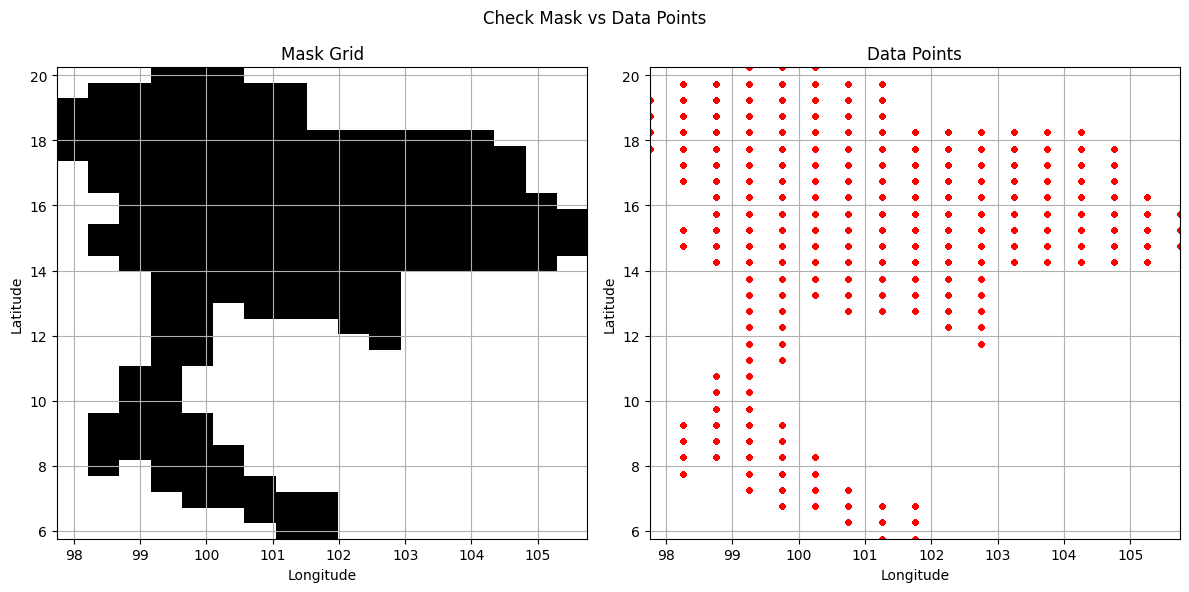

In [54]:
visualize_mask_vs_dataframe(
    mask=mask,
    lat_grid=gridder_X_train.grid_lat,
    lon_grid=gridder_X_train.grid_lon,
    df=df_train,
    lat_key='lat',
    lon_key='lon',
    title='Check Mask vs Data Points'
)


In [55]:
hits, total, all_covered = count_mask_hits(df_train, lat_grid, lon_grid, mask)
print(f"✅ Mask covers {hits}/{total} data points")
if not all_covered:
    print("⚠️ Some data points are not included in the mask.")


✅ Mask covers 296916/296916 data points


In [56]:
valid_pairs = df_train[['lat', 'lon']].drop_duplicates().values.tolist()
unused_count, unused_mask = count_mask_utilization(mask, valid_pairs, lat_grid, lon_grid)
print(f"Unused mask positions: {unused_count}")


Unused mask positions: 0


# Test Loader

In [57]:
import loaders.loader as loader
importlib.reload(loader)
from loaders.loader import create_dataloaders
train_loader, val_loader, test_loader = create_dataloaders(
    grid_X_train_scaled, grid_Y_train_scaled,
    grid_X_val_scaled, grid_Y_val_scaled,
    grid_X_test_scaled, grid_Y_test_scaled,
    pre_seq_len=10, aft_seq_len=1,
    batch_size=16,
    mask=mask,
    timestamps_train=gridder_X_train.timestamps,
    timestamps_val=gridder_X_val.timestamps,
    timestamps_test=gridder_X_test.timestamps
)


In [58]:
print(grid_X_train_scaled.shape)  # (T, H, W, C)
print(grid_Y_train_scaled.shape)  # (T, H, W, 1) or similar
print(len(gridder_X_train.timestamps))  # Should match T
print(mask.shape)  # (H, W)

(1308, 30, 17, 12)
(1308, 30, 17, 1)
1308
(30, 17)


In [59]:
#save gridded_scaled
grid_X_train_scaled, grid_X_val_scaled, grid_X_test_scaled, \
grid_Y_train_scaled, grid_Y_val_scaled, grid_Y_test_scaled, \
scaler_X, scaler_Y = scale_all_grids(
    train_grid_data, val_grid_data, test_grid_data,
    train_target_data, val_target_data, test_target_data
)

In [60]:
# Print example of train_loader
for batch in train_loader:
    x, y, t = batch
    print("Batch X shape:", x.shape)  # [B, T, F, H, W]
    print("Batch Y shape:", y.shape)  # [B, T, C, H, W]
    print("Batch X:", x)              # [B, T, F, H, W]
    print("Batch Y:", y)              # [B, T, C, H, W]
    print("Batch timestamps:", t)      # [B, T]
    break

Batch X shape: torch.Size([16, 10, 12, 30, 17])
Batch Y shape: torch.Size([16, 1, 1, 30, 17])
Batch X: tensor([[[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           ...,
           [-0.5909, -0.5909, -0.5455,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000, -0.5909, -0.5455,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

          [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           ...,
           [-0.8772, -0.8836, -0.8578,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000, -0.8453, -0.8775,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.000

In [63]:
scaler_Y

MinMaxScaler(feature_range=(-1, 1))

In [ ]:
def manual_inverse_transform(scaled, scaler):
    """
    Manually inverse transform a scaled array using MinMaxScaler attributes.
    
    Args:
        scaled: np.ndarray - scaled data with shape [T, H, W, C] or [N, C]
        scaler: fitted MinMaxScaler object
    
    Returns:
        np.ndarray - unscaled data of the same shape
    """
    # Extract min and scale from the scaler
    y_min = scaler.data_min_
    y_max = scaler.data_max_
    r_min, r_max = scaler.feature_range  # Usually (-1, 1)

    # Expand to match shape
    scale = (y_max - y_min)
    scaled_back = (scaled - r_min) / (r_max - r_min)  # Normalize to [0, 1]
    unscaled = scaled_back * scale + y_min
    return unscaled


In [ ]:
# save timestamps
save_name = "_".join(cfg["target_cols"])
# save scaler
with open(f"data/preprocessed/{save_name}/scaler_X_{save_name}.pkl", "wb") as f:
    pickle.dump(scaler_X, f)
with open(f"data/preprocessed/{save_name}/scaler_Y_{save_name}.pkl", "wb") as f:
    pickle.dump(scaler_Y, f)
# save unscaled_data, scaled data, mask, timestamps as npz
np.savez(
    f"data/preprocessed/{save_name}/data_{save_name}.npz",
    grid_X_train=train_grid_data,
    grid_X_val = val_grid_data,
    grid_X_test = test_grid_data,
    grid_Y_train=train_target_data,
    grid_Y_val = val_target_data,
    grid_Y_test = test_target_data,
    grid_X_train_scaled=grid_X_train_scaled,
    grid_X_val_scaled=grid_X_val_scaled,
    grid_X_test_scaled=grid_X_test_scaled,
    grid_Y_train_scaled=grid_Y_train_scaled,
    grid_Y_val_scaled=grid_Y_val_scaled,
    grid_Y_test_scaled=grid_Y_test_scaled,
    mask=mask,
    timestamps_train=gridder_X_train.timestamps,
    timestamps_val=gridder_X_val.timestamps,
    timestamps_test=gridder_X_test.timestamps
)


c:\Users\peera\Desktop\ConvLSTM_drought\.conda\Lib\site-packages\numpy\lib\format.py:382: UserWarning: metadata on a dtype is not saved to an npy/npz. Use another format (such as pickle) to store it.
  d['descr'] = dtype_to_descr(array.dtype)
